## LOAD LIBRARIES

In [211]:
import pandas as pd
import requests
import csv
import datetime
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.pyplot as plt

In [212]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [213]:
%ls
%cd ~/../content/drive/MyDrive/BDP

BESS.ipynb  data_BESS.csv  main_2.ipynb  main.ipynb  temperature_data.csv
/content/drive/MyDrive/BDP


# EXTRACT

### I. Read the CSV file into the selected workspace; <br> II.Retrieve and convert the timestamp.

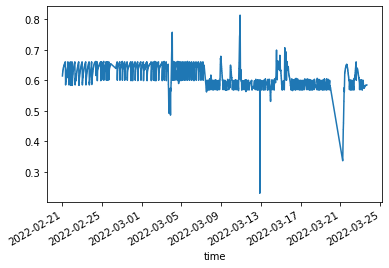

In [214]:
df = pd.read_csv('data_BESS.csv',index_col=0)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()
df['Avg. Cell Temperature'][1:40000].plot()

# TRANSFORM

### III. Find out what is the sampling of the data;

In [215]:
sampling_time = df.index.to_series().diff()

# another way to find out the sampling of the data
sampling_time_check = df.index[1] - df.index[0] 

print(f'The sampling time of the data is {sampling_time[1]}')
##print(sampling_time_check)

The sampling time of the data is 0 days 00:01:00


### IV. Resample to uniform sampling and find a reasonable approach to aggregate/interpolate data

Initial analysis

In [216]:
df.isna().sum()

Active Power Setpoint                        0
SOC                                          0
HVAC Battery part Circulation Fan V1         0
HVAC Battery part heating                    0
HVAC Battery part cooling                    0
Battery part Fan Vb1 Feedback                0
Avg. Cell Temperature                        0
Max. Cell Temperatue                         0
Min. Cell Temperature                        0
String Power                                 0
Outside Temperature                     101330
Ambient Temperature                          0
dtype: int64

In [217]:
# Create a list of numeric columns and binary columns
numeric_cols = ['Active Power Setpoint', 'SOC', 'Battery part Fan Vb1 Feedback', 'Avg. Cell Temperature',
       'Max. Cell Temperatue', 'Min. Cell Temperature', 'String Power',
       'Outside Temperature', 'Ambient Temperature']
binary_cols = ['HVAC Battery part Circulation Fan V1',
       'HVAC Battery part heating', 'HVAC Battery part cooling',]

def check_sampling_time_period(df, sampling_time):
# change the days value to whatever you want
       sampling_time_seconds = sampling_time.total_seconds()
       missing_rows = []

# Loop through the data to check for inconsistencies in the sampling time
       for i in range(1, len(df)): # changed the range to start at 1
              current_time = df.index[i]
              previous_time = df.index[i-1]
              current_sampling_time = current_time - previous_time
              current_sampling_time_seconds = current_sampling_time.total_seconds()
              if current_sampling_time_seconds > sampling_time_seconds: # changed the comparison operator
                     missing_data = df.loc[(df.index > previous_time) & (df.index < current_time)]
                     missing_rows.append(i)
       return missing_rows

In [218]:
sampling_time = timedelta(days=1)
idx_missing_rows_more_than_1_day = check_sampling_time_period(df,sampling_time)
idx_missing_rows_more_than_1_day
idx_missing_rows_more_than_1_day[0]

36536

In [219]:
df_reduced = df.iloc[0:idx_missing_rows_more_than_1_day[1],:]
df_reduced.tail()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature
time,,,,,,,,,,,,
2022-05-05 06:57:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 06:58:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 06:59:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 07:00:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 07:01:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.666106,0.616827,0.0,NaN,0.533894


<function matplotlib.pyplot.show(*args, **kw)>

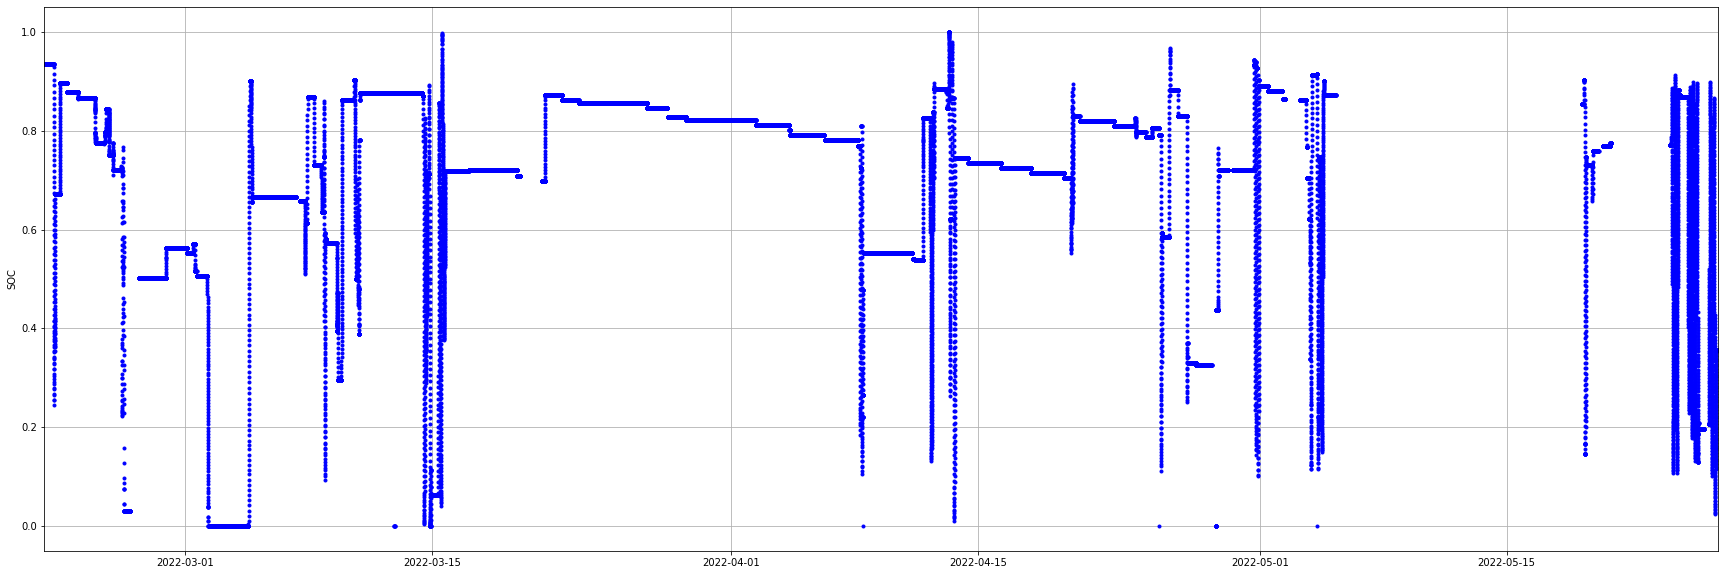

In [220]:
plt.figure(figsize=(30, 10))
plt.plot(df.index, df['SOC'],'b.')
plt.ylabel('SOC')
plt.grid()
plt.xlim(df.index[0], df.index[-1])
#plt.axvline(df.index[df.index == df_reduced.index[-1]], color='red', linestyle='--')
#plt.axvline(df.index[idx_missing_rows_more_than_1_day[0]], color='red', linestyle='--')
#plt.axvline(df.index[df.index == df.iloc[0:idx_missing_rows_more_than_1_day[0],:].tail().index[-1]], color='red', linestyle='--')
plt.show

In [221]:
df_reduced = df.iloc[0:idx_missing_rows_more_than_1_day[1],:]
df_reduced.tail()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature
time,,,,,,,,,,,,
2022-05-05 06:57:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 06:58:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 06:59:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 07:00:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894
2022-05-05 07:01:00+00:00,0.0,0.873125,0.0,0.0,0.0,0.0,0.638462,0.666106,0.616827,0.0,NaN,0.533894


<function matplotlib.pyplot.show(*args, **kw)>

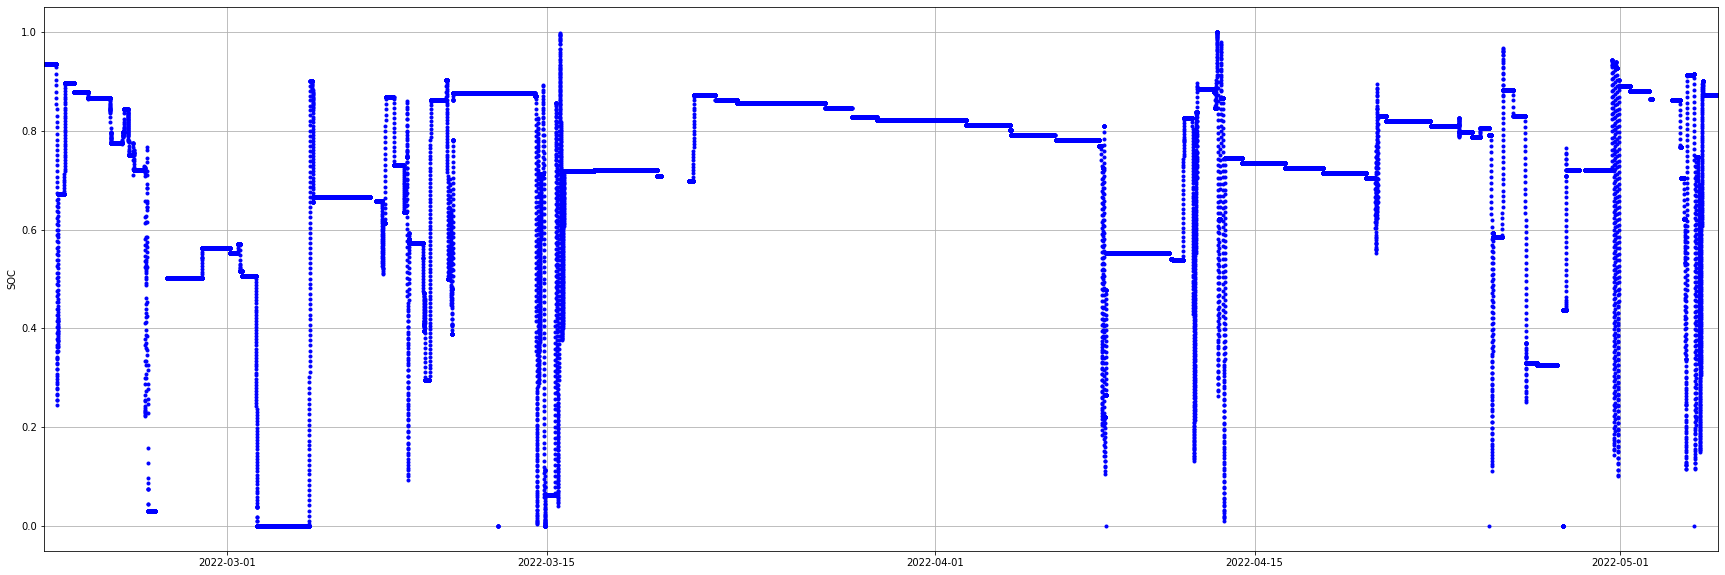

In [222]:
plt.figure(figsize=(30, 10))
plt.plot(df_reduced.index, df_reduced['SOC'],'b.')
plt.ylabel('SOC')
plt.grid()
plt.xlim(df_reduced.index[0], df_reduced.index[-1])
plt.show

### IV. Resample to uniform sampling and find a reasonable approach to aggregate/interpolate data;
A. Create a column that will mark whether the data are original or inferred.

In [223]:
df_start = df_reduced.index[0]
df_end = df_reduced.index[len(df_reduced.index)-1]

time_range = pd.date_range(start=df_start, end=df_end, freq='min')
new_table = pd.DataFrame(index=time_range)


df_reduced[['HVAC Battery part Circulation Fan V1', 'HVAC Battery part heating','HVAC Battery part cooling']] = df_reduced[['HVAC Battery part Circulation Fan V1', 'HVAC Battery part heating','HVAC Battery part cooling']].astype(bool)
df_reduced["DataType"] = "real"

aligned_table = df_reduced.reindex(time_range)
aligned_table.loc[:, 'DataType'] = aligned_table.loc[:, 'DataType'].fillna("inferred")
df_extended = aligned_table.iloc[0:len(aligned_table)-1]
df_extended.tail()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-223-a0f28a9d7bfd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["DataType"] = "real"


,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,DataType
2022-05-05 06:56:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 06:57:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 06:58:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 06:59:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real
2022-05-05 07:00:00+00:00,0.0,0.873125,False,False,False,0.0,0.638462,0.664663,0.615385,0.0,NaN,0.533894,real


### V. Use API to acquire missing outside temperature(at Liptovsky Hradok)
#### A. Normalize the range of temperatures into range from 0 to 1 (consider original range of -15°C to 50°C).

In [224]:
# The latitude and longitude of the location for which you want to retrieve historical weather data
latitude = 49.04
longitude = 19.72

# The start and end date for which you want to retrieve historical weather data
start_date = '2022-02-21'
end_date = '2022-05-05'

# Make a request to the OpenMeteo API
url = f'https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m'
response = requests.get(url)
weather_data = response.json()
time = weather_data['hourly']['time']
temperature = weather_data['hourly']['temperature_2m']
min_temp = -15
max_temp = 50

normalized_temperatures = [(temp - min_temp) / (max_temp - min_temp) for temp in temperature]
data = {'time': time, 'temperature': normalized_temperatures }
df_hourly = pd.DataFrame(data)
df_hourly = df_hourly.iloc[0:len(df_hourly)-16]
datetime_list = [datetime.datetime.strptime(i, '%Y-%m-%dT%H:%M').strftime('%Y-%m-%d %H:%M:%S+00:00') for i in df_hourly['time']]
df_hourly['time'] = datetime_list
df_hourly['time'] = pd.to_datetime(df_hourly['time'])
df_hourly.set_index('time', inplace=True)
df_hourly


,temperature
time,
2022-02-21 00:00:00+00:00,0.263077
2022-02-21 01:00:00+00:00,0.261538
2022-02-21 02:00:00+00:00,0.267692
2022-02-21 03:00:00+00:00,0.266154
2022-02-21 04:00:00+00:00,0.266154
...,...
2022-05-05 03:00:00+00:00,0.341538
2022-05-05 04:00:00+00:00,0.349231
2022-05-05 05:00:00+00:00,0.373846


Resample API hourly data to minutely data

In [225]:
df_minutely = df_hourly.resample('T').interpolate()


<function matplotlib.pyplot.show(*args, **kw)>

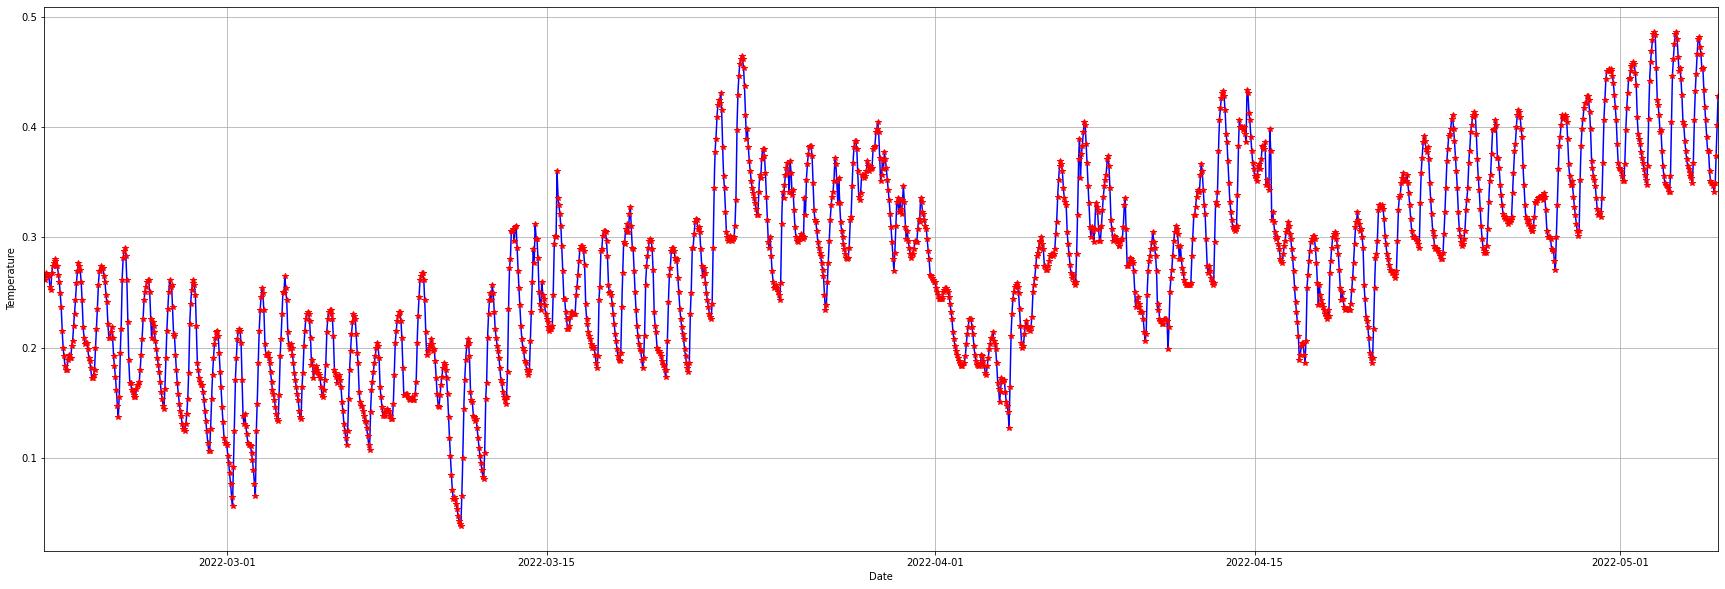

In [226]:
plt.figure(figsize=(30, 10))
plt.plot(df_minutely.index, df_minutely['temperature'],'b')
plt.plot(df_hourly.index, df_hourly['temperature'],'r*')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(df_minutely.index[0], df_minutely.index[-1])
plt.show


2022-02-22 14:08:00+00:00


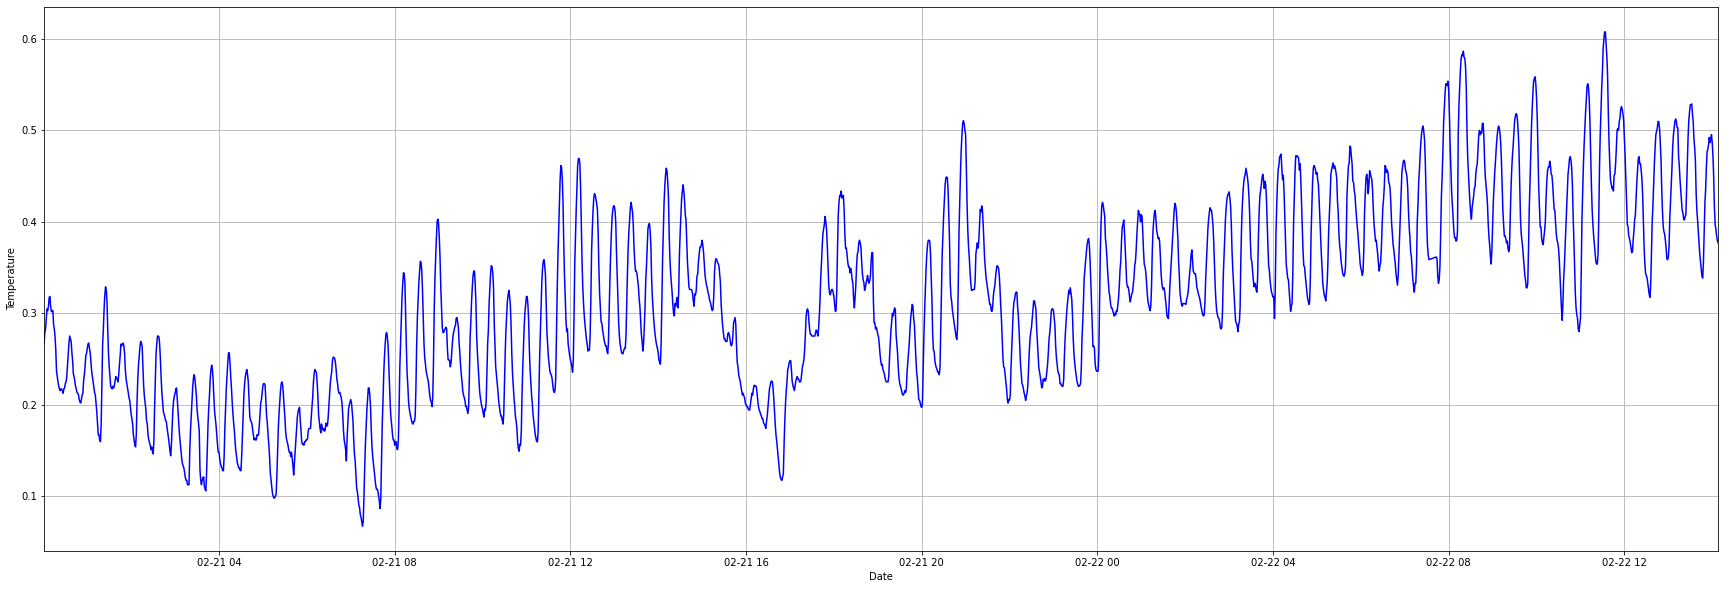

In [227]:
plt.figure(figsize=(30, 10))
plt.plot(df.index, df['Outside Temperature'],'b')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(df.index[0], df['Outside Temperature'].last_valid_index())
plt.show
print(df['Outside Temperature'].last_valid_index())

Plot the original temperature from BESS data


<ipython-input-228-7dd03ef8b0f9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['Outside Temperature Denormalized'] = original_temp


<function matplotlib.pyplot.show(*args, **kw)>

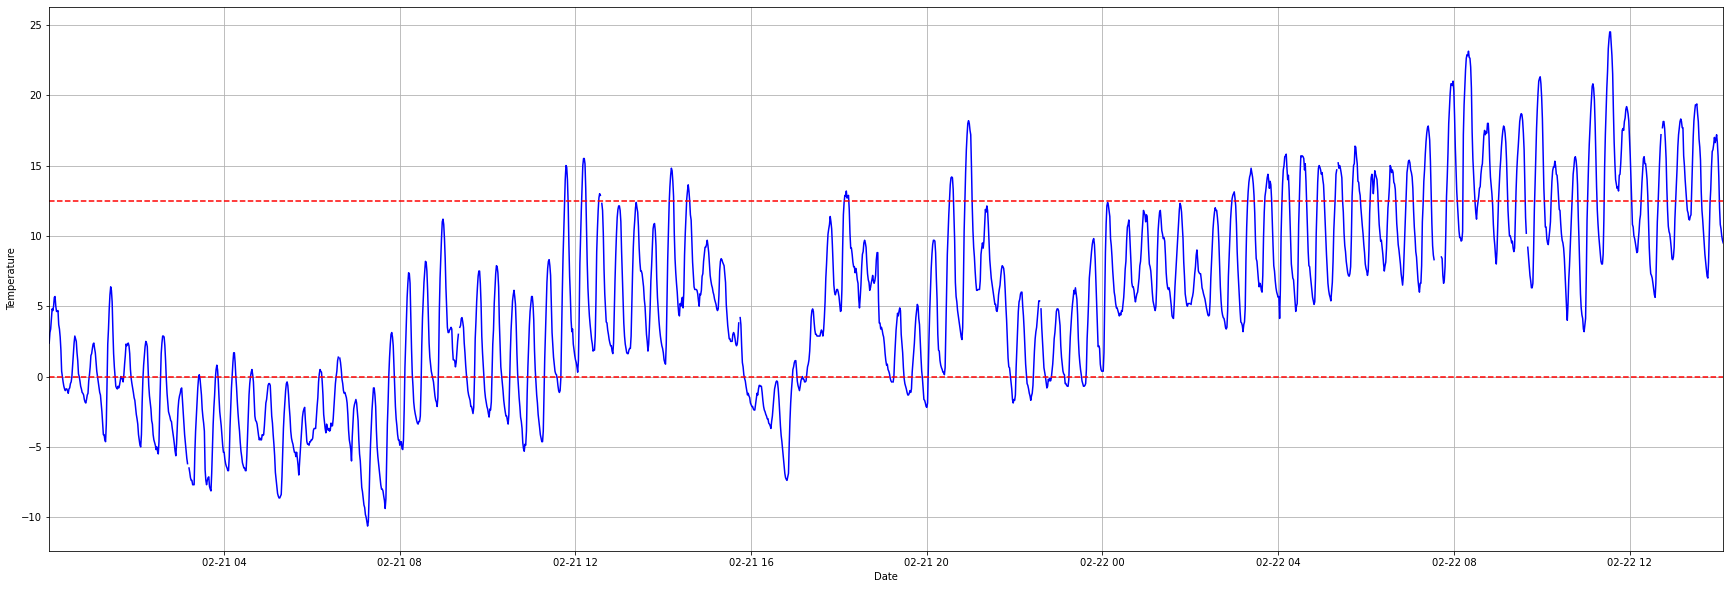

In [228]:
df_extended['Outside Temperature'].values
def denormalize(normalized_temp, original_min, original_max):
    original_temp = (normalized_temp * (original_max - original_min)) + original_min
    return original_temp

original_min = -15
original_max = 50
original_temp = denormalize(df_extended['Outside Temperature'].values, original_min, original_max)

df_extended['Outside Temperature Denormalized'] = original_temp

plt.figure(figsize=(30, 10))
plt.plot(df_extended.index, df_extended['Outside Temperature Denormalized'],'b')
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=12.5, color='red', linestyle='--')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(df_extended.index[0], df_extended['Outside Temperature Denormalized'].last_valid_index())
plt.show

Compare original outside temperature data with API data from Liptovsky hrádok

<function matplotlib.pyplot.show(*args, **kw)>

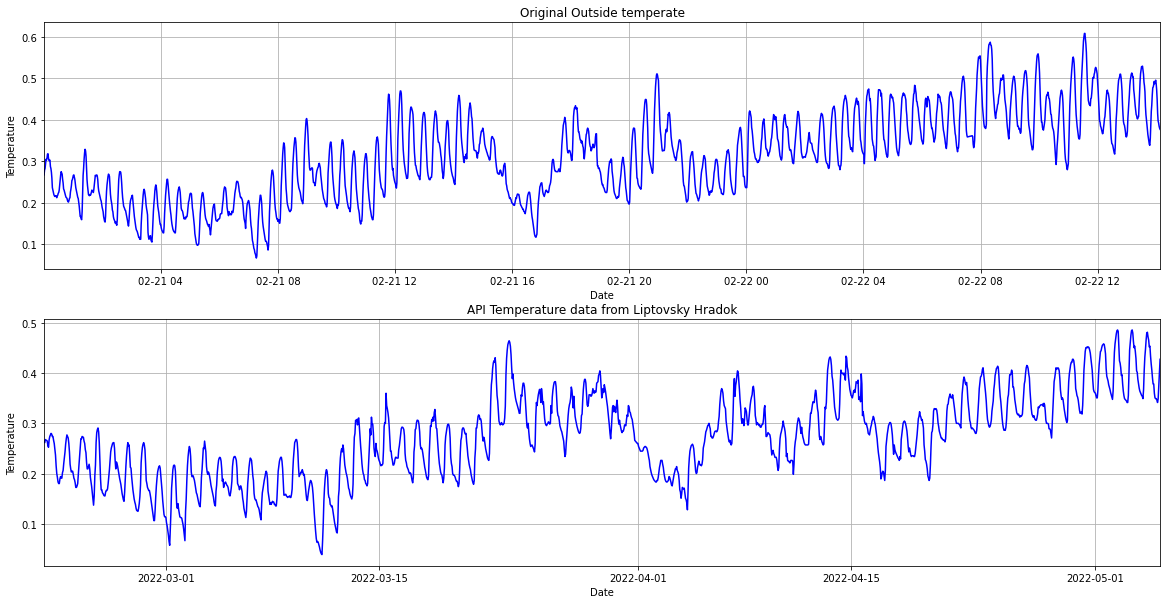

In [229]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.plot(df.index, df['Outside Temperature'],'b')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title('Original Outside temperate')
plt.grid()
plt.xlim(df.index[0], df['Outside Temperature'].last_valid_index())
plt.subplot(212)
plt.plot(df_hourly.index, df_hourly['temperature'],'b')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title('API Temperature data from Liptovsky Hradok')
plt.grid()
plt.xlim(df_hourly.index[0], df_hourly.index[-1])
plt.show


Replace Outside Temperature with API temperature data

In [230]:
df_extended['Outside Temperature'] = df_minutely['temperature']
df_extended['Outside Temperature Denormalized'] = denormalize(df_extended['Outside Temperature'].values, original_min, original_max)
df_extended.isna().sum()

<ipython-input-230-17f80217ea4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['Outside Temperature'] = df_minutely['temperature']
<ipython-input-230-17f80217ea4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['Outside Temperature Denormalized'] = denormalize(df_extended['Outside Temperature'].values, original_min, original_max)


Active Power Setpoint                   7338
SOC                                     7338
HVAC Battery part Circulation Fan V1    7338
HVAC Battery part heating               7338
HVAC Battery part cooling               7338
Battery part Fan Vb1 Feedback           7338
Avg. Cell Temperature                   7338
Max. Cell Temperatue                    7338
Min. Cell Temperature                   7338
String Power                            7338
Outside Temperature                        0
Ambient Temperature                     7338
DataType                                   0
Outside Temperature Denormalized           0
dtype: int64

Fill missing (NaN) values by propagating the last valid observation forward

In [231]:
df_filled = df_extended.ffill()

In [232]:
df_filled.head()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,DataType,Outside Temperature Denormalized
2022-02-21 00:01:00+00:00,0.0,0.935,False,False,False,0.0,0.613942,0.632212,0.595433,0.0,0.263051,0.638462,real,2.098333
2022-02-21 00:02:00+00:00,0.0,0.935,False,False,False,0.0,0.613942,0.632212,0.595433,0.0,0.263026,0.638462,real,2.096667
2022-02-21 00:03:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.632212,0.595433,0.0,0.263000,0.637019,real,2.095000
2022-02-21 00:04:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.633894,0.595433,0.0,0.262974,0.635337,real,2.093333
2022-02-21 00:05:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.633894,0.596875,0.0,0.262949,0.635337,real,2.091667


In [233]:
df_filled.dtypes

Active Power Setpoint                   float64
SOC                                     float64
HVAC Battery part Circulation Fan V1       bool
HVAC Battery part heating                  bool
HVAC Battery part cooling                  bool
Battery part Fan Vb1 Feedback           float64
Avg. Cell Temperature                   float64
Max. Cell Temperatue                    float64
Min. Cell Temperature                   float64
String Power                            float64
Outside Temperature                     float64
Ambient Temperature                     float64
DataType                                 object
Outside Temperature Denormalized        float64
dtype: object

### VI. Split charging and discharging to separate columns (both real and desired);

In [234]:
df_filled['Desired Charging'] = np.where((df_filled['Active Power Setpoint'] <= 1) & (df_filled['Active Power Setpoint'] > 0) , df_filled['Active Power Setpoint'], 0)
df_filled['Desired Discharging'] =abs(np.where((df_filled['Active Power Setpoint'] < 0) & (df_filled['Active Power Setpoint'] > -1) , df_filled['Active Power Setpoint'], 0))

df_filled['Real Charging'] = np.where((df_filled['String Power'] <= 1) & (df_filled['String Power'] > 0) , df_filled['String Power'], 0)
df_filled['Real Discharging'] =  abs(np.where((df_filled['String Power'] < 0) & (df_filled['String Power'] > -1) , df_filled['String Power'], 0))

df_filled.head()

,Active Power Setpoint,SOC,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,DataType,Outside Temperature Denormalized,Desired Charging,Desired Discharging,Real Charging,Real Discharging
2022-02-21 00:01:00+00:00,0.0,0.935,False,False,False,0.0,0.613942,0.632212,0.595433,0.0,0.263051,0.638462,real,2.098333,0.0,0.0,0.0,0.0
2022-02-21 00:02:00+00:00,0.0,0.935,False,False,False,0.0,0.613942,0.632212,0.595433,0.0,0.263026,0.638462,real,2.096667,0.0,0.0,0.0,0.0
2022-02-21 00:03:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.632212,0.595433,0.0,0.263000,0.637019,real,2.095000,0.0,0.0,0.0,0.0
2022-02-21 00:04:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.633894,0.595433,0.0,0.262974,0.635337,real,2.093333,0.0,0.0,0.0,0.0
2022-02-21 00:05:00+00:00,0.0,0.935,False,False,False,0.0,0.615385,0.633894,0.596875,0.0,0.262949,0.635337,real,2.091667,0.0,0.0,0.0,0.0


### VII. Aggregate data to the daily sum of binary values and daily mean of numeric.

In [235]:
binary_columns = [col for col in df_filled.columns if df_filled[col].dtype == 'bool']
integer_columns = [col for col in df_filled.columns if df_filled[col].dtype == 'float64']

In [236]:
print(binary_columns)
print(integer_columns)

['HVAC Battery part Circulation Fan V1', 'HVAC Battery part heating', 'HVAC Battery part cooling']
['Active Power Setpoint', 'SOC', 'Battery part Fan Vb1 Feedback', 'Avg. Cell Temperature', 'Max. Cell Temperatue', 'Min. Cell Temperature', 'String Power', 'Outside Temperature', 'Ambient Temperature', 'Outside Temperature Denormalized', 'Desired Charging', 'Desired Discharging', 'Real Charging', 'Real Discharging']


In [237]:
agg_dict = {col:'sum' for col in binary_columns}
agg_dict.update({col:'mean' for col in integer_columns})

aggregated = df_filled.groupby(pd.Grouper(freq='D')).agg(agg_dict)
aggregated.head()

,HVAC Battery part Circulation Fan V1,HVAC Battery part heating,HVAC Battery part cooling,Active Power Setpoint,SOC,Battery part Fan Vb1 Feedback,Avg. Cell Temperature,Max. Cell Temperatue,Min. Cell Temperature,String Power,Outside Temperature,Ambient Temperature,Outside Temperature Denormalized,Desired Charging,Desired Discharging,Real Charging,Real Discharging
2022-02-21 00:00:00+00:00,272,0,272,0.002613,0.822302,0.0,0.630471,0.652584,0.602333,-0.001100,0.248480,0.637806,1.151216,0.045490,0.042182,0.038978,0.040078
2022-02-22 00:00:00+00:00,92,0,92,-0.000556,0.883087,0.0,0.630524,0.645577,0.610546,-0.000808,0.222145,0.595092,-0.560590,0.000278,0.000833,0.000000,0.000808
2022-02-23 00:00:00+00:00,126,0,126,-0.001875,0.857874,0.0,0.628165,0.643575,0.605254,-0.004503,0.226339,0.593035,-0.287986,0.003611,0.005486,0.002047,0.006550
2022-02-24 00:00:00+00:00,65,0,65,-0.002278,0.779985,0.0,0.643406,0.658542,0.625024,-0.004547,0.199730,0.589276,-2.017535,0.009757,0.012035,0.007008,0.011555
2022-02-25 00:00:00+00:00,247,0,247,-0.033750,0.372266,0.0,0.641237,0.663868,0.618370,-0.035786,0.213035,0.632605,-1.152743,0.036250,0.070000,0.030085,0.065871


### IX. Find a reasonable way to render weekly seasonality in data;


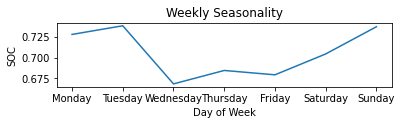

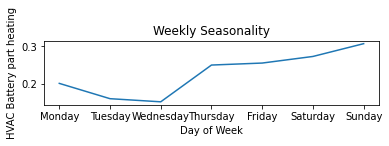

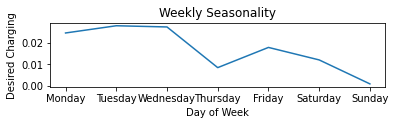

In [238]:
# Add a column for the day of the week
data = df_filled
# Add a column for the day of the week
data['day_of_week'] = data.index.dayofweek

# Create a dictionary to map the numerical values to the day names
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

# Use the map method to replace the numerical values with the day names
data['day_of_week'] = data['day_of_week'].map(day_names)

# Group data by day of the week and calculate the mean
weekday_mean = data.groupby('day_of_week').mean()

# Reorder the index of the weekday_mean dataframe
weekday_mean = weekday_mean.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the mean values by day of the week
plt.subplot(311)
plt.plot(weekday_mean.index, weekday_mean['SOC'])
plt.xlabel('Day of Week')
plt.ylabel('SOC')
plt.title('Weekly Seasonality')
plt.show()
plt.subplot(312)
plt.plot(weekday_mean.index, weekday_mean['HVAC Battery part heating'])
plt.xlabel('Day of Week')
plt.ylabel('HVAC Battery part heating')
plt.title('Weekly Seasonality')
plt.show()
plt.subplot(313)
plt.plot(weekday_mean.index, weekday_mean['Desired Charging'])
plt.xlabel('Day of Week')
plt.ylabel('Desired Charging')
plt.title('Weekly Seasonality')
plt.show()


### X. Identify the error in the HVAC command realization when sending the binary command that did not change HVAC's state;


Pozorovali sme trend, že po vypnutí ohrevu sa priemerná teplota barérie prirodzene znížila vplyvom umiestnenia BESS vo vonkajšom prostredí (dôkaz - teplota zo snímača BESS je podobná vonkajšej teplote z API). Na niektorých úsekoch si môžeme všimnút píky, že teplota začala po vypnutí ohrevu narastať. Tento jav bolo spôsobený tým, že došlo k poklesu hodnoty SOC, teda k vybíjaniu a batéria sa začala prirodzene zahrievať.

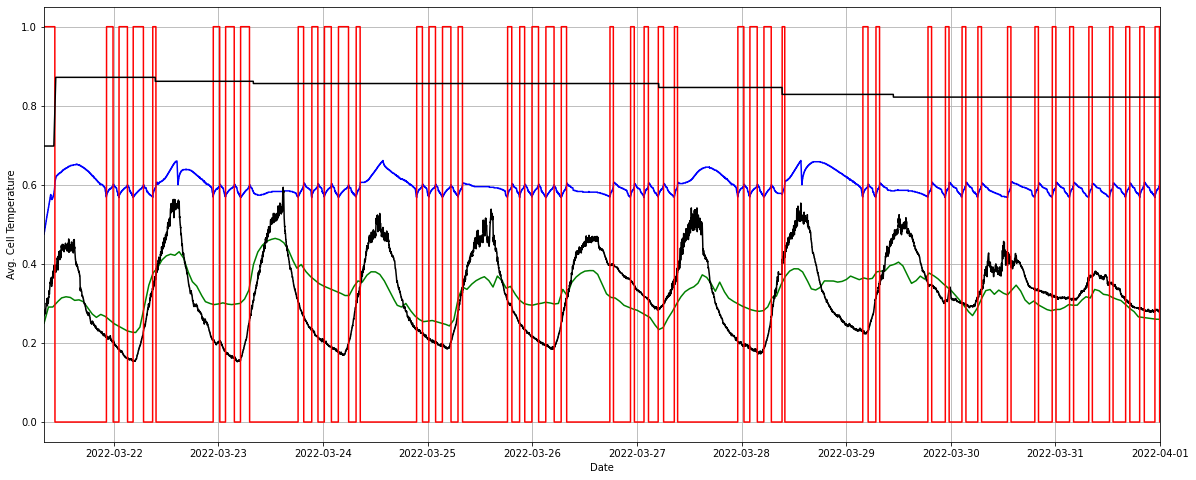

In [260]:
start_time = pd.Timestamp('2022-03-21 08:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
#plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.ylabel('Avg. Cell Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time )
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')
plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['HVAC Battery part heating'][mask],'r')
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'k')
plt.plot()
plt.show()

### XI. Plot change-points in the data (due to anomaly or drift)

Červenou čiarkovej čiarou sú zvyraznené change points - prvá červená čiara označuje drift, kde výraznú zmenu priemernej teploty batérie, čo je pravdepodobne spôsobené presunom batérie z vnútorného prostredia von <br>  zelenou je vyznačená oblasť, počas ktorej bola batéria pravdepodobne vypnutá, čo može spôsobiť aj odlišné správanie teploty (nábeh senzora) a tieto dáta môžeme označit ako anomálie, pretože by mohli zanášať chybu do machine-learning modelu, čevnené štvorčeky predstavujú anomálie, resp. outliery, ktoré mohli napríklad nastať pri výpadku snímača 

<function matplotlib.pyplot.show(*args, **kw)>

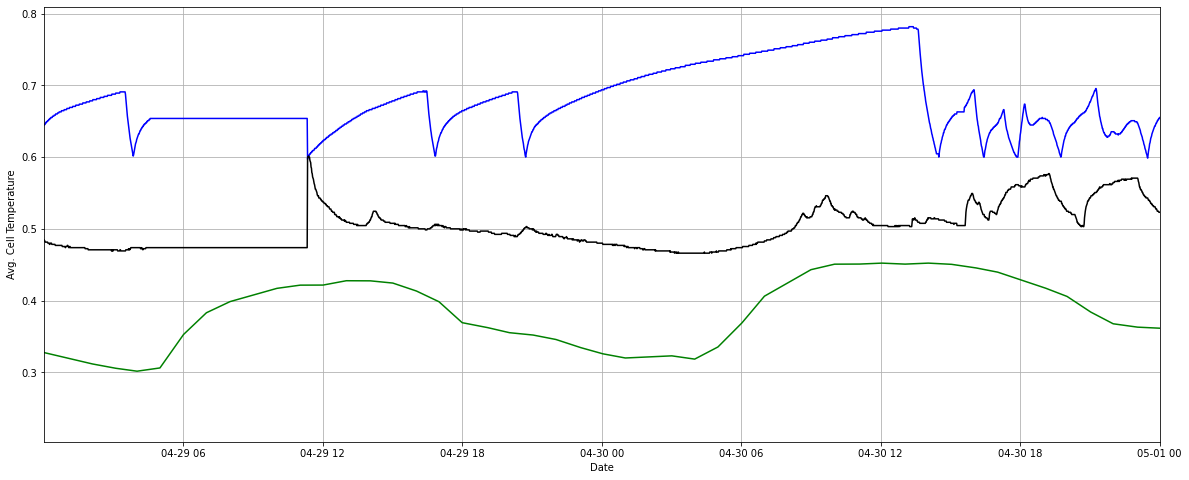

In [304]:
start_time = pd.Timestamp('2022-04-29 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-05-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
plt.plot(df_filled.index[idx_zero], df_filled['Avg. Cell Temperature'][idx_zero],'rs')

# v prípade, že chceme ukázať vplvyv vonkajšej teploty odpoznámkovať

plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')

plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-07 08:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-06 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-07 16:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-08 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-08 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-11 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-13 20:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-25 20:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-20 00:06:00+0000', tz='UTC')], color='green', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-21 10:00:00+0000', tz='UTC')], color='green', linestyle='--')
plt.ylabel('Avg. Cell Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time) 

plt.show

### XII. Identify meaningful points where set point and real string power deviate

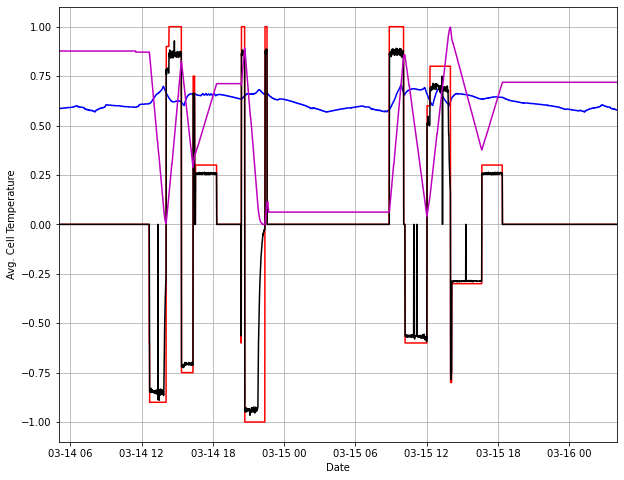

In [296]:
start_time = pd.Timestamp('2022-03-14 05:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-03-16 04:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(10, 8))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
plt.plot(df_filled.index[mask], df_filled['Active Power Setpoint'][mask],'r')
plt.plot(df_filled.index[mask], df_filled['String Power'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'m')
#plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.ylabel('Avg. Cell Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time )
plt.plot()
plt.show()




Vidíme, že medzi dynamikou skutočného nabíjania/vybíjania a set-pointom je vždy určitá odchýlka a v skutočnosti nikdy nedosiahneme požadovanú dynamikou. Pozorujeme, že v jednej oblasti bol setpoint nastavený na vybíjanie batérie, avšak v skutočnosti k nemu nedochádzalo. 

<function matplotlib.pyplot.show(*args, **kw)>

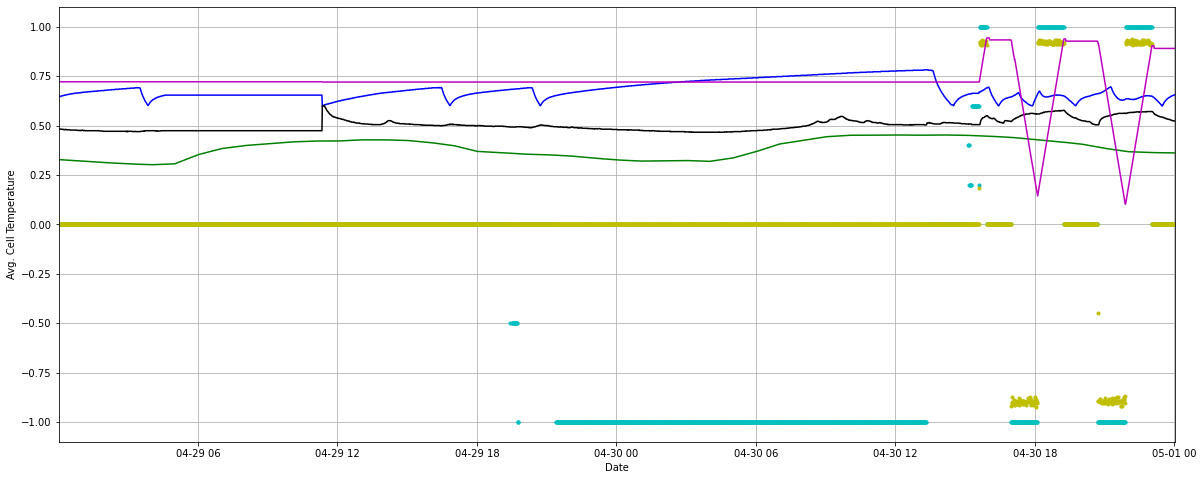

In [308]:
start_time = pd.Timestamp('2022-04-29 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-05-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
plt.plot(df_filled.index[idx_zero], df_filled['Avg. Cell Temperature'][idx_zero],'rs')

# v prípade, že chceme ukázať vplvyv vonkajšej teploty odpoznámkovať

plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')

plt.plot(df_filled.index[mask], df_filled['Active Power Setpoint'][mask],'c.')
plt.plot(df_filled.index[mask], df_filled['String Power'][mask],'y.')
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'m')

plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-07 08:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-06 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-07 16:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-08 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-08 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-11 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-13 20:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-25 20:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-20 00:06:00+0000', tz='UTC')], color='green', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-21 10:00:00+0000', tz='UTC')], color='green', linestyle='--')
plt.ylabel('Avg. Cell Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time) 

plt.show

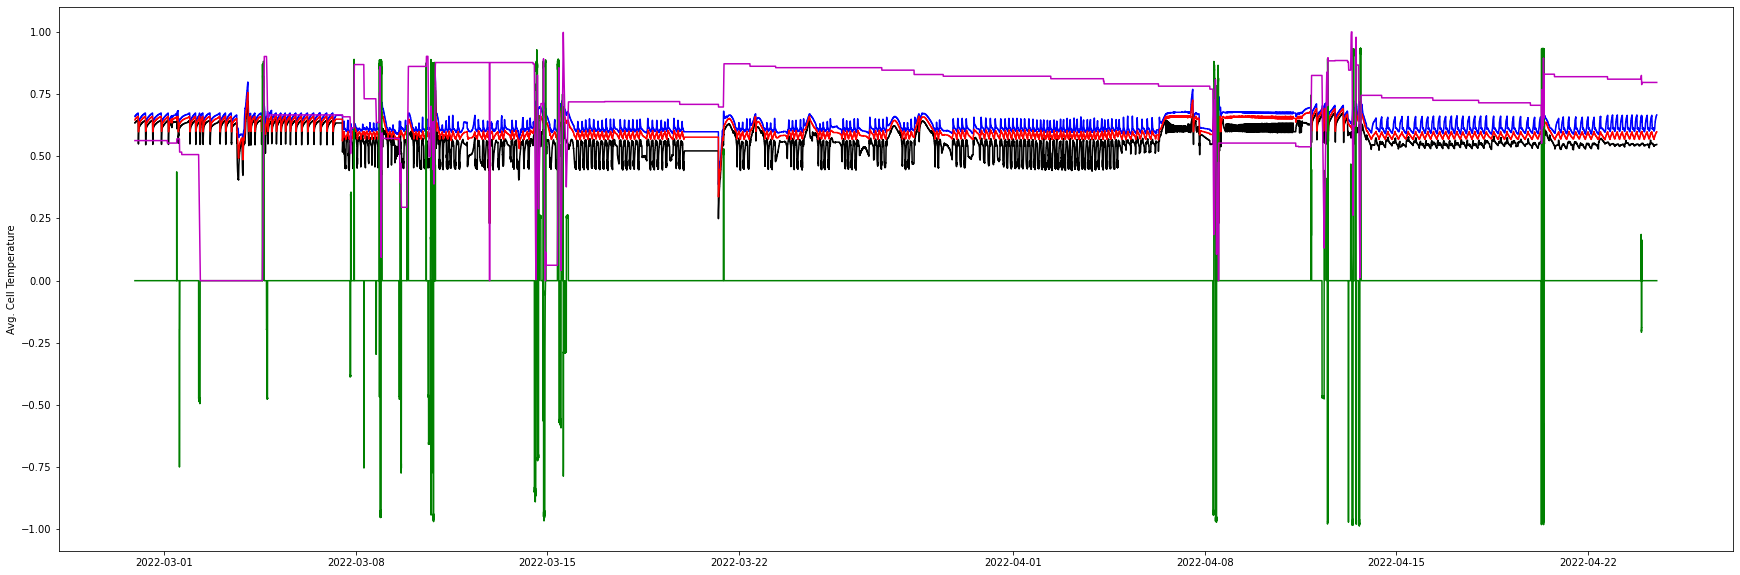

In [241]:
plt.figure(figsize=(30, 10))
plt.plot(df_filled.index[10000:90000], df_filled['Max. Cell Temperatue'][10000:90000],'b')
plt.ylabel('Avg. Cell Temperature')


plt.plot(df_filled.index[10000:90000], df_filled['Min. Cell Temperature'][10000:90000],'k')
plt.ylabel('Avg. Cell Temperature')


plt.plot(df_filled.index[10000:90000], df_filled['Avg. Cell Temperature'][10000:90000],'r')
plt.ylabel('Avg. Cell Temperature')

plt.plot(df_filled.index[10000:90000], df_filled['String Power'][10000:90000],'g')


plt.plot(df_filled.index[10000:90000], df_filled['SOC'][10000:90000],'m')



plt.show()

In [300]:
len(df_filled)

105540

(738274.0006944444, 738276.0006944444)

<Figure size 2160x720 with 0 Axes>

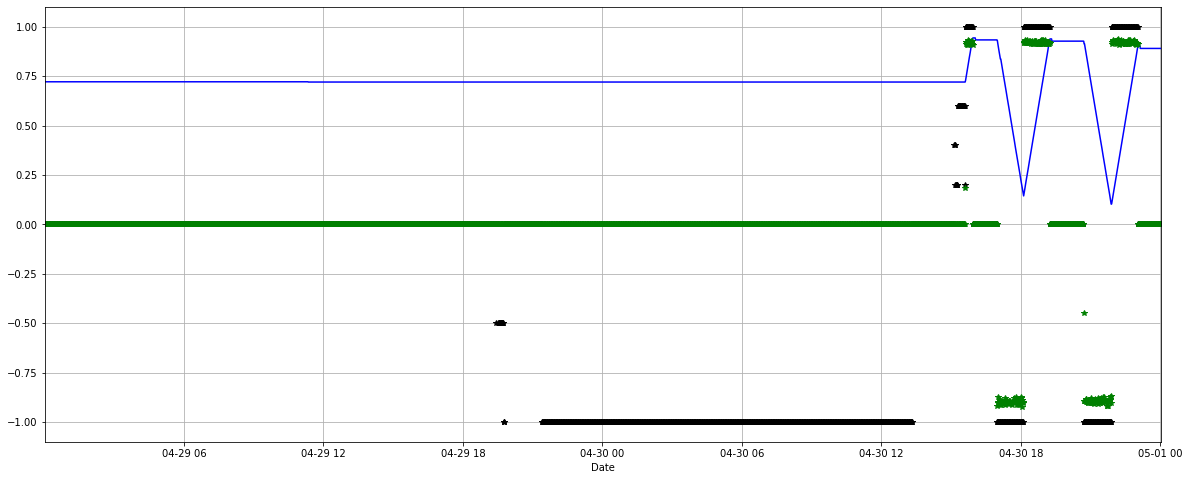

In [302]:
plt.figure(figsize=(30, 10))
start_time = pd.Timestamp('2022-04-29 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-05-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'b')

plt.plot(df_filled.index[mask], df_filled['Active Power Setpoint'][mask],'k*')
plt.plot(df_filled.index[mask], df_filled['String Power'][mask],'g*')

plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time) 





In [243]:
df_filled.columns

Index(['Active Power Setpoint', 'SOC', 'HVAC Battery part Circulation Fan V1',
       'HVAC Battery part heating', 'HVAC Battery part cooling',
       'Battery part Fan Vb1 Feedback', 'Avg. Cell Temperature',
       'Max. Cell Temperatue', 'Min. Cell Temperature', 'String Power',
       'Outside Temperature', 'Ambient Temperature', 'DataType',
       'Outside Temperature Denormalized', 'Desired Charging',
       'Desired Discharging', 'Real Charging', 'Real Discharging',
       'day_of_week'],
      dtype='object')

In [244]:
start_time = pd.Timestamp('2022-03-15 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-03-18 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)

Identify the error in the HVAC command realization when sending the binary
command that did not change HVAC's state


<function matplotlib.pyplot.show(*args, **kw)>

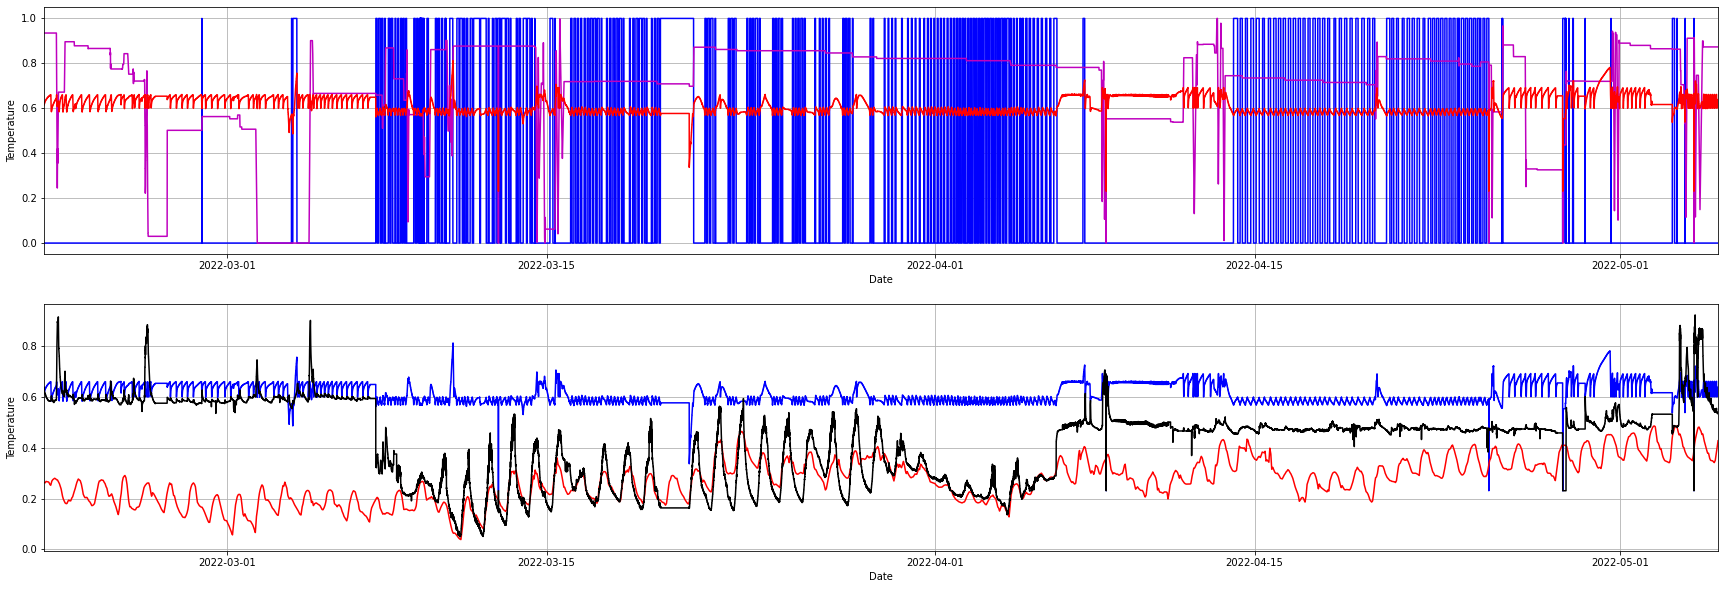

In [245]:
plt.figure(figsize=(30, 10))
plt.subplot(211)
plt.plot(df_filled.index, df_filled['HVAC Battery part heating'],'b')
plt.plot(df_filled.index, df_filled['SOC'],'m')
plt.plot(df_filled.index, df_filled['Avg. Cell Temperature'],'r')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(df_filled.index[0], df_filled.index[-1])

plt.subplot(212)
plt.plot(df_filled.index, df_filled['Avg. Cell Temperature'],'b')
plt.plot(df_filled.index, df_filled['Outside Temperature'],'r')
plt.plot(df_filled.index, df_filled['Ambient Temperature'],'k')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(df_filled.index[0], df_filled.index[-1])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

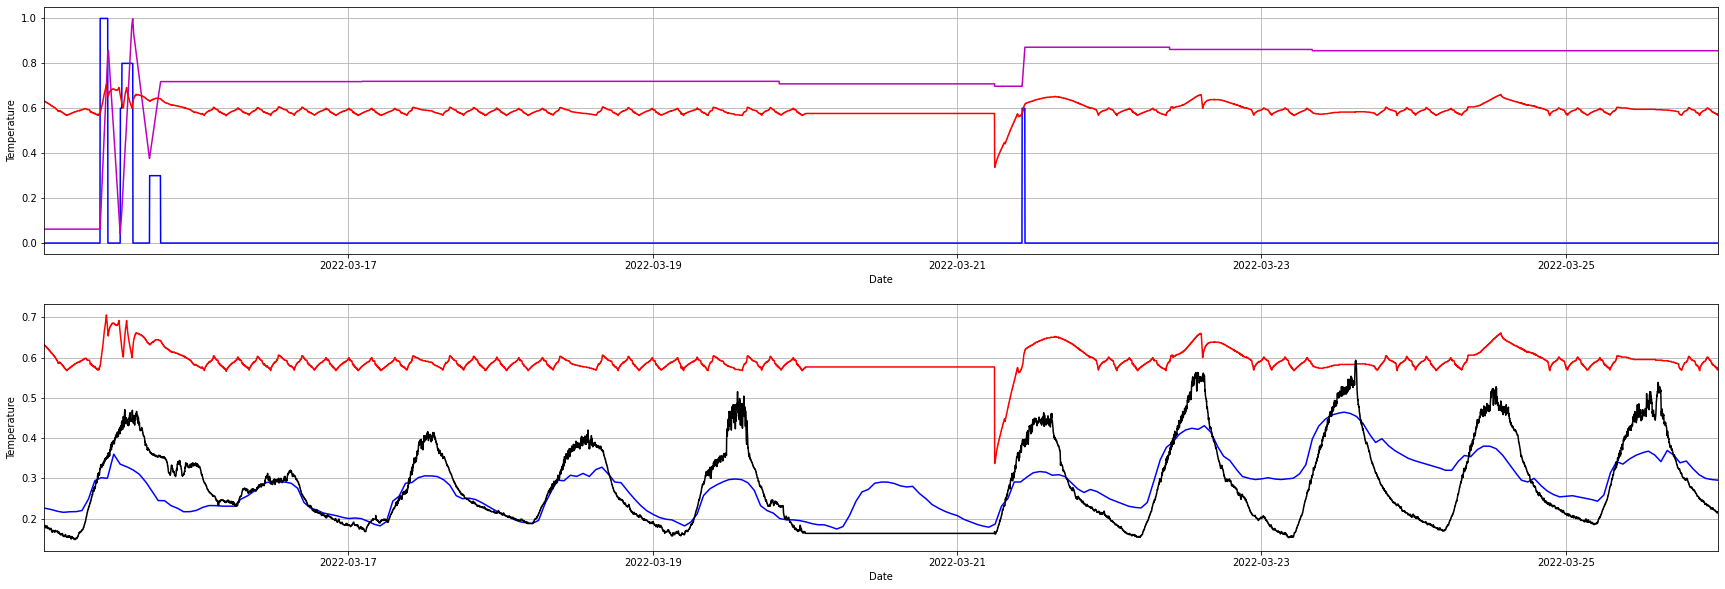

In [246]:
start_time = pd.Timestamp('2022-03-15 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-03-26 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)
plt.figure(figsize=(30, 10))
plt.subplot(211)
plt.plot(df_filled.index[mask], df_filled['Desired Charging'][mask],'b')
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'m')
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'r')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time )

plt.subplot(212)
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'r')
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'b')
plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time )
plt.show

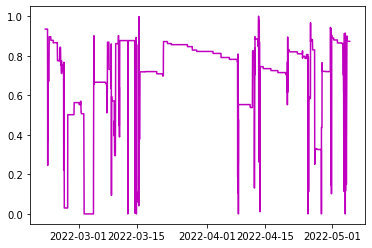

In [247]:
plt.plot(df_filled.index, df_filled['SOC'],'m')

### Plot change-points in the data (due to anomaly or drift);


Červenou čiarkovej čiarou sú zvyraznené change points - prvá červená čiara označuje drift, kde výraznú zmenu priemernej teploty batérie, čo je pravdepodobne spôsobené presunom batérie z vnútorného prostredia von <br>  zelenou je vyznačená oblasť, počas ktorej bola batéria pravdepodobne vypnutá, čo može spôsobiť aj odlišné správanie teploty (nábeh senzora) a tieto dáta môžeme označit ako anomálie, pretože by mohli zanášať chybu do machine-learning modelu, čevnené štvorčeky predstavujú anomálie, resp. outliery, ktoré mohli napríklad nastať pri výpadku snímača 

<function matplotlib.pyplot.show(*args, **kw)>

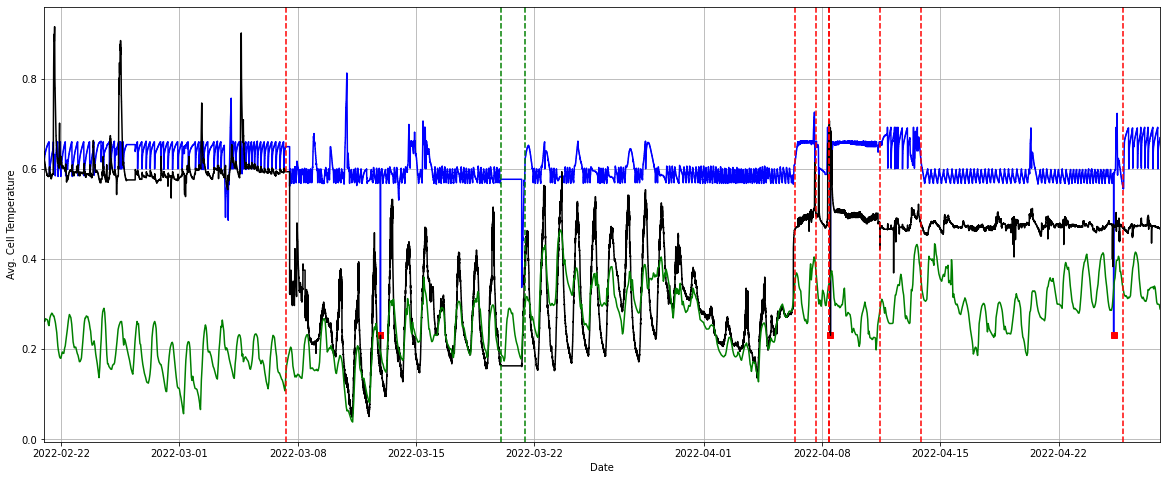

In [283]:
start_time = pd.Timestamp('2022-02-21 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-28 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
plt.plot(df_filled.index[idx_zero], df_filled['Avg. Cell Temperature'][idx_zero],'rs')

# v prípade, že chceme ukázať vplvyv vonkajšej teploty odpoznámkovať

#plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
#plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')

plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-07 08:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-06 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-07 16:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-08 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-08 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-11 10:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-13 20:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-04-25 20:00:00+0000', tz='UTC')], color='red', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-20 00:06:00+0000', tz='UTC')], color='green', linestyle='--')
plt.axvline(df_filled.index[df_filled.index == pd.Timestamp('2022-03-21 10:00:00+0000', tz='UTC')], color='green', linestyle='--')
plt.ylabel('Avg. Cell Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time) 

plt.show

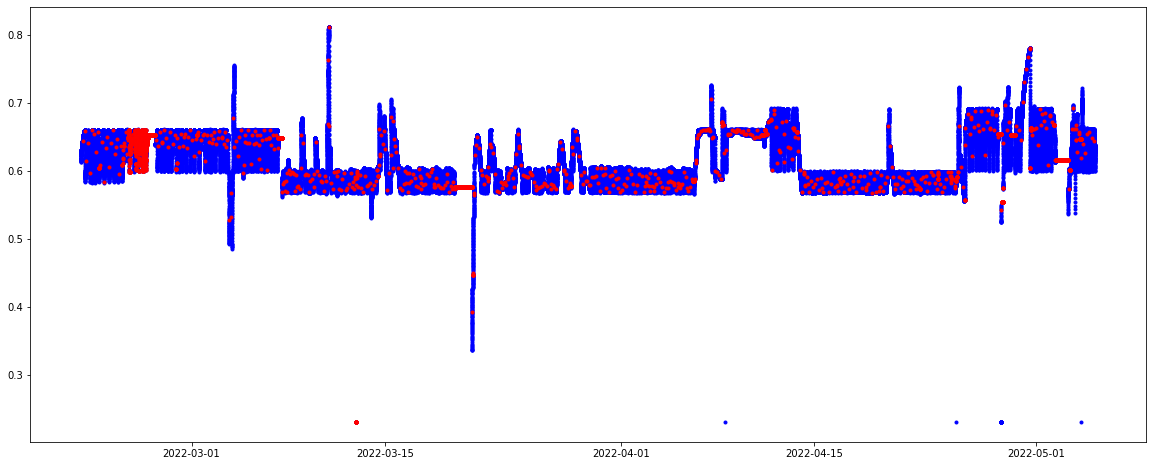

In [249]:
real_data = (df_filled['DataType'] == 'real')
inferred_data = (df_filled['DataType'] == 'inferred') 

plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[real_data], df_filled['Avg. Cell Temperature'][real_data],'b.')
plt.plot(df_filled.index[inferred_data], df_filled['Avg. Cell Temperature'][inferred_data],'r.')


<function matplotlib.pyplot.show(*args, **kw)>

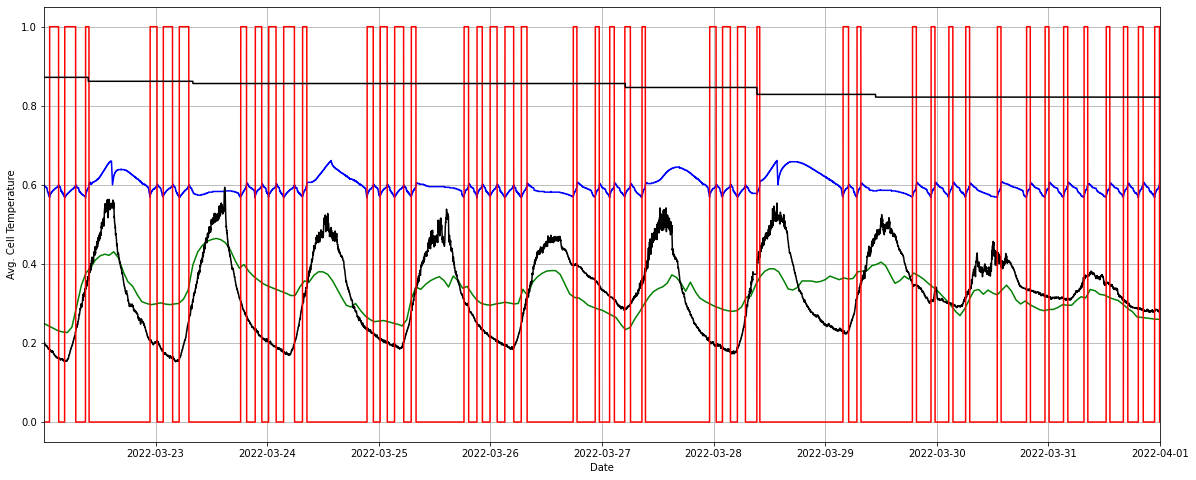

In [250]:
start_time = pd.Timestamp('2022-03-22 00:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-04-01 00:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(20, 8))
plt.plot(df_filled.index[mask], df_filled['Avg. Cell Temperature'][mask],'b')
#plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.ylabel('Avg. Cell Temperature')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time )
plt.plot(df_filled.index[mask], df_filled['Outside Temperature'][mask],'g')
plt.plot(df_filled.index[mask], df_filled['Ambient Temperature'][mask],'k')
plt.plot(df_filled.index[mask], df_filled['HVAC Battery part heating'][mask],'r')
plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'k')
plt.plot()


plt.show

<function matplotlib.pyplot.show(*args, **kw)>

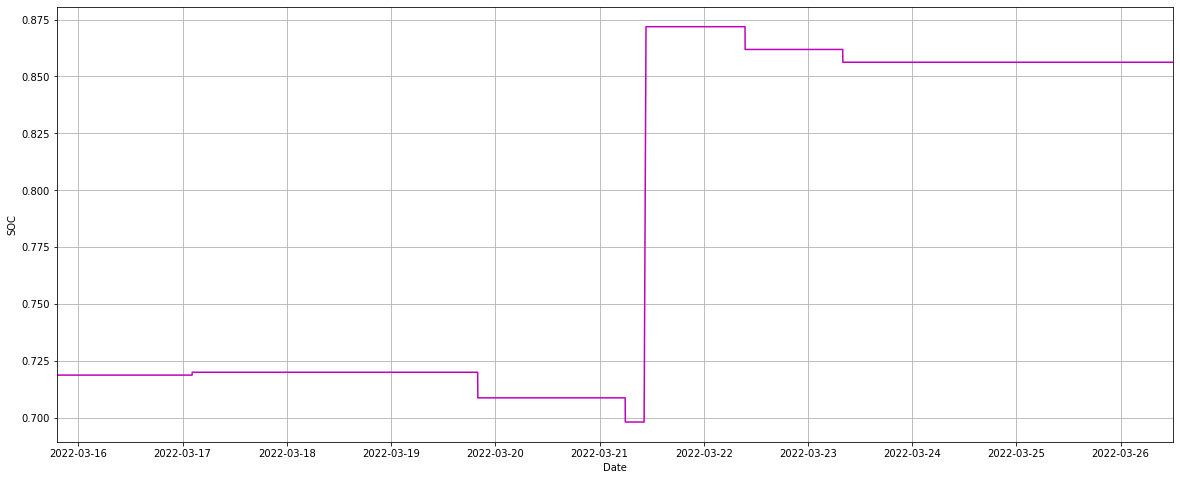

In [251]:
start_time = pd.Timestamp('2022-03-15 19:01:00+0000', tz='UTC')
end_time = pd.Timestamp('2022-03-26 12:01:00+0000', tz='UTC')

mask = (df_filled.index >= start_time) & (df_filled.index <= end_time)


idx_zero = (df_filled['Avg. Cell Temperature'] <= 0.3)

plt.figure(figsize=(20, 8))
plt.ylabel('SOC')
plt.xlabel('Date')
plt.grid()
plt.xlim(start_time, end_time )

plt.plot(df_filled.index[mask], df_filled['SOC'][mask],'m')
plt.plot()


plt.show